In [1]:
library(Seurat)
library(data.table)
library(ggplot2)

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3


# Analysis

In [2]:
datasetName = "/stor/public/hcad/Heart_Heart_Wang2020/Heart_Heart_Wang2020"

In [4]:
# Load the organized dataset
data.matrix <- read.csv(paste0(datasetName,'_expression.tsv'),header = TRUE, sep='\t',row.names = 1)

In [5]:
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)

In [6]:
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, meta.data = data.metadata, min.cells = 3,min.features = 500)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

In [7]:
dataobj

An object of class Seurat 
47740 features across 8383 samples within 1 assay 
Active assay: RNA (47740 features)

# QC

In [8]:
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")

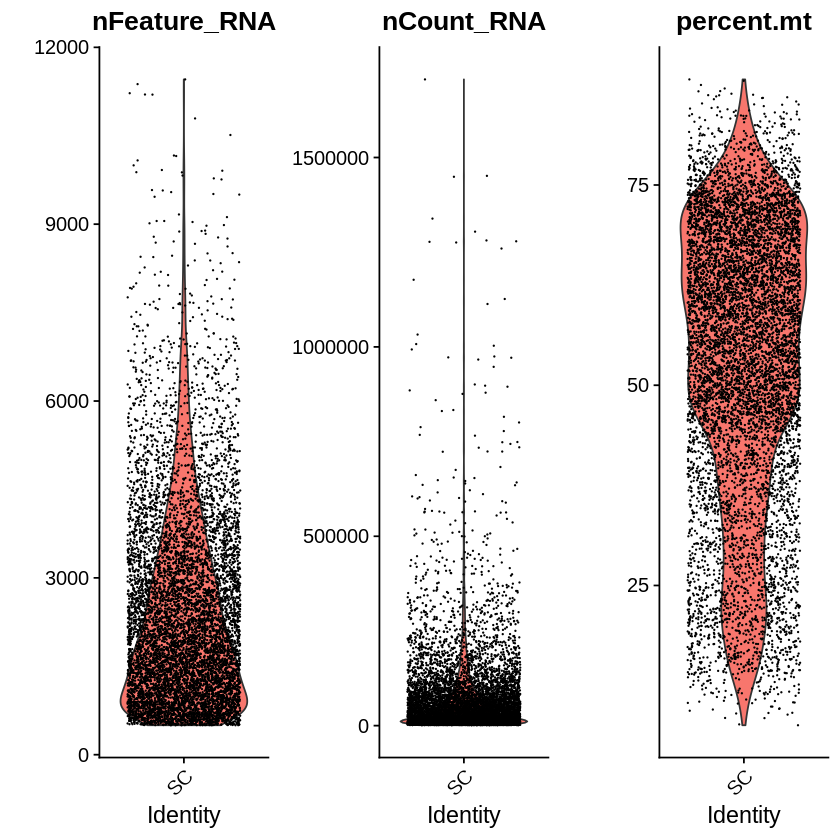

In [8]:
VlnPlot(dataobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0.01)

In [9]:
percent.mt.thre = 72
nFeature_RNA_range = c(500, 9000)

In [10]:
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre & nCount_RNA<500000)

In [11]:
dataobj

An object of class Seurat 
47740 features across 7231 samples within 1 assay 
Active assay: RNA (47740 features)

# Normalization

In [11]:
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Centering and scaling data matrix


# PCA

In [12]:
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))

PC_ 1 
Positive:  TMSB4X, IFITM3, B2M, SPARCL1, VIM, TMSB10, MGP, GSN, FTL, IFI27 
	   CD74, DCN, RNASE1, MYL6, C7, FTLP3, PECAM1, TM4SF1, SERPING1, GNG11 
	   TIMP1, HLA-DRB1, SPARC, SH3BGRL3, CLU, PLAC9, FN1, VWF, HES1, ITM2A 
Negative:  MYL2, PAM, MYH6, NPPB, MYL7, MYL4, SRP14-AS1, PALM2, ALS2CR11, SLN 
	   PWAR5, IFNLR1, SYNPR, GCOM1, RP11-159H10.3, MIEF2, SPINK2, BRINP3, KIAA1524, RP11-44B19.1 
	   BRI3BP, PIK3CD-AS2, RP11-248N22.1, RP11-230C9.2, AC005618.6, RP11-287D1.4, ZBED6CL, RP11-486O13.5, RP5-837I24.4, RP11-867G23.10 
PC_ 2 
Positive:  MS4A6A, AIF1, TYROBP, CD163, FCER1G, C1QA, MRC1, LAPTM5, MS4A7, MS4A4A 
	   C1QB, F13A1, ALOX5AP, LCP1, FCGR2A, VSIG4, C1orf162, CD74, HLA-DRA, LYVE1 
	   PLEK, FOLR2, HLA-DRB1, HCLS1, RNASE1, CTSS, IGSF6, CCL3L3, PTPRC, MSR1 
Negative:  DCN, MFAP5, SERPINF1, C7, LUM, C1R, PTN, CDH19, FBLN1, PRELP 
	   ADH1B, ABCA8, CFD, ABI3BP, MGST1, PCOLCE2, COL1A2, CCDC80, SCARA5, C1S 
	   DPT, PDGFRA, COL6A3, VCAN, SCN7A, APOD, FSTL1, FBN1, C3, CFH 
PC_ 

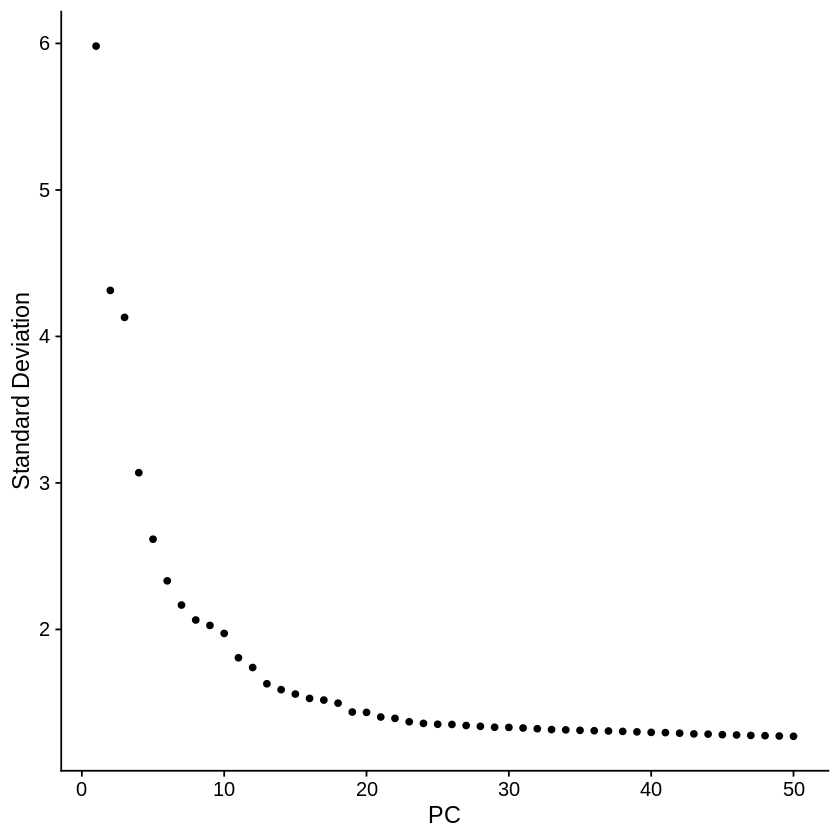

In [13]:
ElbowPlot(dataobj,50)
# select 30

In [14]:
# run Umap
dataobj <- RunUMAP(dataobj, dims = 1:30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”17:41:03 UMAP embedding parameters a = 0.9922 b = 1.112
17:41:03 Read 7231 rows and found 30 numeric columns
17:41:03 Using Annoy for neighbor search, n_neighbors = 30
17:41:03 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
17:41:04 Writing NN index file to temp file /tmp/Rtmpb0LZaX/file67d228960e4e
17:41:04 Searching Annoy index using 1 thread, search_k = 3000
17:41:07 Annoy recall = 100%
17:41:07 Commencing smooth kNN distance calibration using 1 thread
17:41:08 Initializing from normalized Laplacian + noise
17:41:08 Commencing optimizatio

Warning message in if (label) {:
“the condition has length > 1 and only the first element will be used”Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

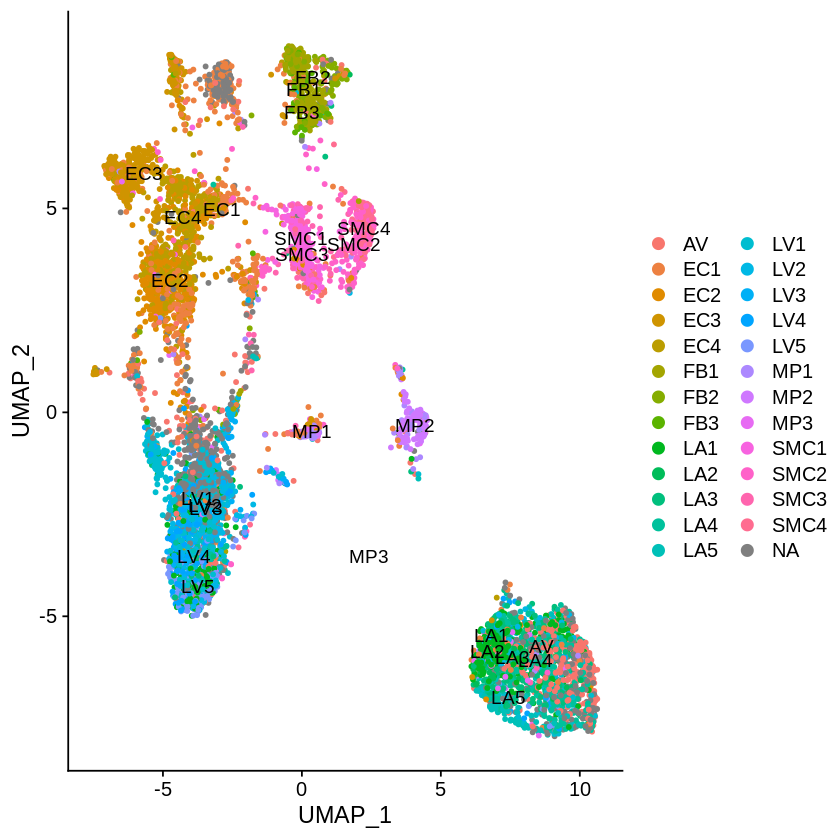

In [16]:
p_umap <- DimPlot(dataobj, reduction = "umap", group.by = 'cell_cluster',label = dataobj$orig.ident, pt.size=1)
p_umap

In [17]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap, width = 8, height = 5)

# Clustering

In [18]:
dataobj <- FindNeighbors(dataobj, dims = 1:30, k.param = 30)

Computing nearest neighbor graph
Computing SNN


In [19]:
dataobj <- FindClusters(dataobj, resolution = 1)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7231
Number of edges: 621478

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8129
Number of communities: 18
Elapsed time: 1 seconds


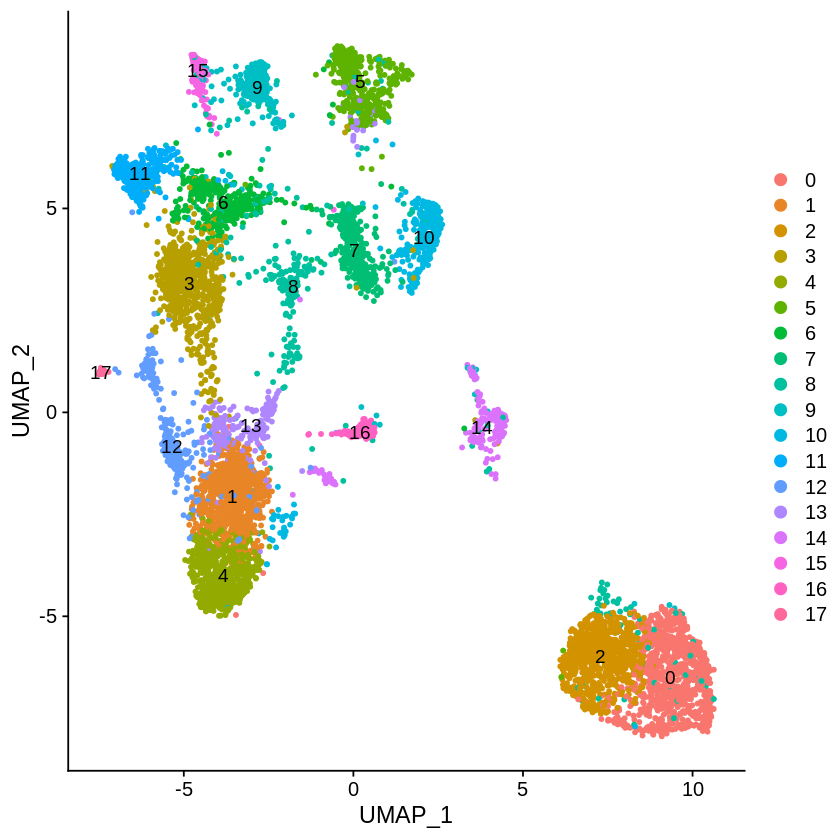

In [29]:
p_umap2 <-DimPlot(dataobj, reduction = "umap",label = TRUE, pt.size=1)
p_umap2

In [30]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap2, width = 8, height = 5)

In [24]:
dataobj.markers <- FindAllMarkers(dataobj,  test.use='wilcox', min.pct=0.2, thresh.use=0.2, min.diff.pct=0.1, only.positive=TRUE, return.thresh=0.05)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12
Calculating cluster 13
Calculating cluster 14
Calculating cluster 15
Calculating cluster 16
Calculating cluster 17


In [25]:
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

# Annotation

In [4]:
dataobj <- readRDS(paste0(datasetName,".seuratobj.rds"))

In [69]:
dataobj.markers[dataobj.markers['cluster']==16,]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
CD2,0.000000e+00,1.7794038,0.509,0.009,0.000000e+00,16,CD2
CCL5,6.099046e-251,2.3472294,0.640,0.030,2.911684e-246,16,CCL5
PTPRC.1,7.279912e-183,2.0336600,0.623,0.042,3.475430e-178,16,PTPRC
CD3D,1.494405e-169,1.6050142,0.360,0.013,7.134290e-165,16,CD3D
GZMA,7.261560e-167,0.9220121,0.246,0.005,3.466669e-162,16,GZMA
CD69,1.412372e-157,1.3474650,0.307,0.010,6.742663e-153,16,CD69
TRBV25-1,8.736879e-149,1.1164765,0.351,0.014,4.170986e-144,16,TRBV25-1
TRBC2,1.141712e-147,1.6214874,0.518,0.035,5.450535e-143,16,TRBC2
NKG7,1.011743e-105,0.6875820,0.219,0.007,4.830062e-101,16,NKG7


In [75]:
dataobj.markers[dataobj.markers['gene']=='C1QC',]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
C1QC,1.268141e-286,0.6662783,0.486,0.019,6.054106e-282,14,C1QC


In [5]:
new.cluster.ids <- c('Heart-Musle Tissue-Cardiomyocyte Cell-MYL7 MYL4', 
                     'Heart-Musle Tissue-Cardiomyocyte Cell-MYH7 MYL4', 
                     'Heart-Musle Tissue-Cardiomyocyte Cell-MYL7 MYL4', 
                     'Heart-Epithelial Tissue-Endothelial cell-EMCN',
                     'Heart-Musle Tissue-Cardiomyocyte Cell-MYH7 TNNC1', 
                     'Heart-Connective Tissue-Fibrocyte-DCN',#5
                     'Heart-Epithelial Tissue-Endothelial cell-TNNC1',
                     'Heart-Musle Tissue-Smooth muscle cell-ACTA2',
                     'Heart-Epithelial Tissue-Endothelial cell-CAV1',
                     'Heart-Musle Tissue-Cardiomyocyte Cell-MYL7 TNNC1', 
                     'Heart-Musle Tissue-Smooth muscle cell-ACTA2',#10
                     'Heart-Epithelial Tissue-Endothelial cell-PLVAP',
                     'Heart-Musle Tissue-Cardiomyocyte Cell-MYL4',
                     'Heart-Musle Tissue-Cardiomyocyte Cell-MYL4',
                     'Heart-Connective Tissue-Macrophage-C1QA C1QC',
                     'Heart-Epithelial Tissue-Endothelial cell-TNNC1',#15
                     'Heart-Connective Tissue-Lymphocyte-CD69',
                     'Heart-Epithelial Tissue-Endothelial cell-TNNC1')

Warning message:
“Cannot find identity NA”Warning message:
“Cannot find identity NA”Warning message:
“Cannot find identity NA”Warning message:
“Cannot find identity NA”Warning message:
“Cannot find identity NA”Warning message:
“Cannot find identity NA”Warning message:
“Cannot find identity NA”Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

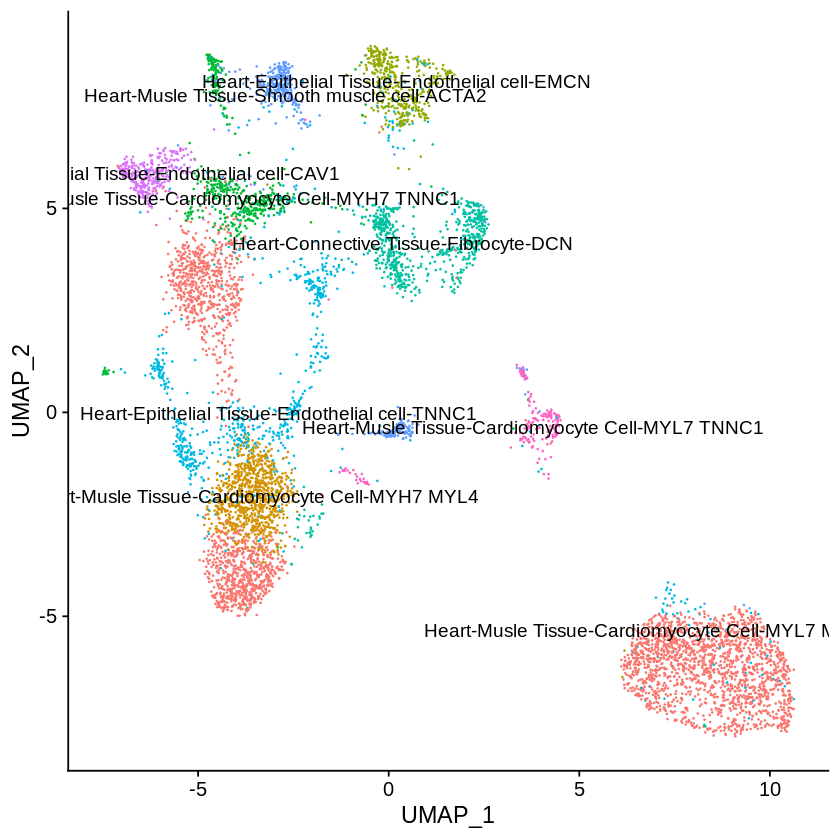

In [6]:
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)
plot <- DimPlot(dataobj, reduction = "umap",label = TRUE, pt.size = 0.1) + NoLegend()
plot

In [8]:
dataobj@meta.data$hcad.label <- Idents(dataobj)

In [9]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [10]:
df_hca <- data.frame(rownames(dataobj@meta.data),dataobj@meta.data$hcad.label)
colnames(df_hca) <- c('cell_ID', 'cell_cluster')

In [11]:
write.table(df_hca, file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)

In [79]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = plot, width = 8, height = 5)

# update annotation

In [43]:
dataobj <- readRDS("/stor/public/hcad/db_v1/Heart_Heart_Wang2020/Heart_Heart_Wang2020.seuratobj.dbupload_v1.rds")

In [55]:
table(dataobj$original_name[dataobj$hcad_name == "Heart-Connective tissue-Fibrocyte-DCN"])


  AV  EC1  EC2  EC3  EC4  FB1  FB3  LA1  LA3  LA5  LV1  LV2  LV3  LV4  LV5  MP1 
   9   12    7    2    2    1    1    1    2    1    1    9    1    1    8    2 
 MP3   NA SMC1 SMC2 SMC3 SMC4 
   1   13  220  171   81  113 

In [52]:
dataobj$cell_type[dataobj$hcad_name == "Heart-Muscle tissue-Smooth muscle cell-ACTA2"& dataobj$original_name=="NA"] <- "NA"
dataobj$tissue_type[dataobj$hcad_name == "Heart-Muscle tissue-Smooth muscle cell-ACTA2"& dataobj$original_name=="NA"] <- "NA"
dataobj$marker_gene[dataobj$hcad_name == "Heart-Muscle tissue-Smooth muscle cell-ACTA2"& dataobj$original_name=="NA"] <- "NA"
dataobj$hcad_name[dataobj$hcad_name == "Heart-Muscle tissue-Smooth muscle cell-ACTA2"& dataobj$original_name=="NA"] <- "Unknown"

In [54]:
dataobj$cell_type[dataobj$hcad_name == "Heart-Epithelial tissue-Endothelial cell-EMCN"] <- "Fibrocyte"
dataobj$tissue_type[dataobj$hcad_name == "Heart-Epithelial tissue-Endothelial cell-EMCN"] <- "Connective tissue"
dataobj$marker_gene[dataobj$hcad_name == "Heart-Epithelial tissue-Endothelial cell-EMCN"] <- "DCN LUM"
dataobj$hcad_name[dataobj$hcad_name == "Heart-Epithelial tissue-Endothelial cell-EMCN"] <- "Heart-Connective tissue-Fibrocyte-DCN LUM"

In [56]:
dataobj$cell_type[dataobj$hcad_name == "Heart-Connective tissue-Fibrocyte-DCN"] <- "Smooth muscle cell"
dataobj$tissue_type[dataobj$hcad_name == "Heart-Connective tissue-Fibrocyte-DCN"] <- "Muscle tissue"
dataobj$marker_gene[dataobj$hcad_name == "Heart-Connective tissue-Fibrocyte-DCN"] <- "ACTA2"
dataobj$hcad_name[dataobj$hcad_name == "Heart-Connective tissue-Fibrocyte-DCN"] <- "Heart-Muscle tissue-Smooth muscle cell-ACTA2"

In [59]:
saveRDS(dataobj, "/stor/public/hcad/db_v1.1/Heart_Heart_Wang2020/Heart_Heart_Wang2020.seuratobj.dbupload_v1.rds")